# Spatial Autocorrelation

This tutorial explores spatial autocorrelation using open source GIS libraries in the `pysal` family. The tutorial is based on [Exploratory Analysis of Spatial Data: Spatial Autocorrelation](https://pysal.org/esda/notebooks/spatial_autocorrelation_for_areal_unit_data.html#) by Levi Wolf and Serge Rey.

I have marked it up to resolve some replication errors, to shorten for topics of relevance to INFO 612 students, and to explain where relevant.

In [32]:
import warnings

import geopandas as gpd
import libpysal as lps
import mapclassify as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn
from geopandas import GeoDataFrame
from matplotlib import colors
from shapely.geometry import Point

import esda

In [ ]:
# You may first have to install some of these libraries. You can do this within a notebook using this notation:
! pip install esda
! pip install mapclassify

## Loading data
This uses two layers on housing in Berlin. One is a `geojson` of neighborhood boundaries. The other is a `csv` containing web scraped data from AirBNB listings.

In [2]:
# Load the geojson data directly from GitHub using this notation
gdf = gpd.read_file("https://raw.githubusercontent.com/ljwolf/geopython/master/data/berlin-neighbourhoods.geojson")

# and view the data
gdf

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52...."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52...."
...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


In [3]:
# Similar procedure here for CSV data from GitHub. Though note that pandas cannot directly take the URL as a parameter.
url = "https://raw.githubusercontent.com/ljwolf/geopython/master/data/berlin-listings.csv.gz"
bl_df = pd.read_csv(url)
bl_df

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.00
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.29
2,2,1153584,https://www.airbnb.com/rooms/1153584,20170507222235,2017-05-08,Gästezimmer Berlin-Pankow,Unser Gästezimmer befindet sich im Dachgeschos...,"Wenn Ihr eine anspruchsvolles Ambiente sucht, ...",Unser Gästezimmer befindet sich im Dachgeschos...,none,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.27
3,3,7832750,https://www.airbnb.com/rooms/7832750,20170507222235,2017-05-08,Sonniges Doppelzimmer+Nice Price!,Welcome! Hier vermiete ich ein kleines Wohlfüh...,Die Wohnung ist durch Ihre Lage sehr schön hel...,Welcome! Hier vermiete ich ein kleines Wohlfüh...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,5.43
4,4,11634962,https://www.airbnb.com/rooms/11634962,20170507222235,2017-05-08,Room for womens in Pankow 30 min from the city,Gemütliches Zimmer im ruhigen Teil von Berlin....,"Es handelt sich um ein großes, gemütliches Zim...",Gemütliches Zimmer im ruhigen Teil von Berlin....,none,...,9.0,f,NaN,NaN,f,flexible,f,f,1,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20048,20571,17511241,https://www.airbnb.com/rooms/17511241,20170507222235,2017-05-08,Private nice room near Metro U8 and Tegel Airport,Very tidy and simple flat in white town. It's ...,NaN,Very tidy and simple flat in white town. It's ...,none,...,9.0,f,NaN,NaN,t,moderate,f,f,1,6.89
20049,20572,597413,https://www.airbnb.com/rooms/597413,20170507222235,2017-05-08,Cozy flat,"Schlafplatz für 2 Personen auf der Couch, sehr...",We have a sunny room in Berlin Reinickendorf n...,We have a sunny room in Berlin Reinickendorf n...,none,...,9.0,f,NaN,NaN,f,strict,f,f,3,0.20
20050,20573,4712991,https://www.airbnb.com/rooms/4712991,20170507222235,2017-05-08,Loft im grünen Norden Berlins,Willkommen in unserem Loft unter dem Dach. Zu ...,Das Apartment ist hell und freundlich geschnit...,Willkommen in unserem Loft unter dem Dach. Zu ...,none,...,9.0,f,NaN,NaN,f,moderate,f,f,2,0.73
20051,20574,13054913,https://www.airbnb.com/rooms/13054913,20170507222235,2017-05-08,"Nice, modern, quite single room in the green N...",Meine Unterkunft liegt in einem Mehrfamilienha...,My apartment is situated in the northern outsk...,My apartment is situated in the northern outsk...,none,...,10.0,f,NaN,NaN,f,flexible,f,f,1,0.77


In [4]:
# now we'll define the geometry and projection for that csv
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude, strict=True)]
crs = 4326  # this is an EPSG projection code

# and transform it into a spatial data frame
bl_gdf = GeoDataFrame(bl_df, crs=crs, geometry=geometry)
bl_gdf.head()

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,f,NaN,NaN,t,flexible,f,f,3,2.00,POINT (13.39609 52.58331)
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,f,NaN,NaN,t,flexible,f,f,1,1.29,POINT (13.39858 52.57642)
2,2,1153584,https://www.airbnb.com/rooms/1153584,20170507222235,2017-05-08,Gästezimmer Berlin-Pankow,Unser Gästezimmer befindet sich im Dachgeschos...,"Wenn Ihr eine anspruchsvolles Ambiente sucht, ...",Unser Gästezimmer befindet sich im Dachgeschos...,none,...,f,NaN,NaN,f,flexible,f,f,1,1.27,POINT (13.39926 52.58922)
3,3,7832750,https://www.airbnb.com/rooms/7832750,20170507222235,2017-05-08,Sonniges Doppelzimmer+Nice Price!,Welcome! Hier vermiete ich ein kleines Wohlfüh...,Die Wohnung ist durch Ihre Lage sehr schön hel...,Welcome! Hier vermiete ich ein kleines Wohlfüh...,none,...,f,NaN,NaN,t,flexible,f,f,1,5.43,POINT (13.39558 52.58231)
4,4,11634962,https://www.airbnb.com/rooms/11634962,20170507222235,2017-05-08,Room for womens in Pankow 30 min from the city,Gemütliches Zimmer im ruhigen Teil von Berlin....,"Es handelt sich um ein großes, gemütliches Zim...",Gemütliches Zimmer im ruhigen Teil von Berlin....,none,...,f,NaN,NaN,f,flexible,f,f,1,1.45,POINT (13.39366 52.58375)


## Exploring the data
We'll start by exploring median AirBNB prices in Berlin.


In [5]:
# define a price variable
bl_gdf["price"] = bl_gdf["price"].astype("float32")

# create a new spatial data frame by joining boundaries to listings data
sj_gdf = gpd.sjoin(
    gdf, bl_gdf, how="inner", predicate="intersects", lsuffix="left", rsuffix="right"
)

# calculate the median price
median_price_gb = sj_gdf["price"].groupby([sj_gdf["neighbourhood_group"]]).mean()
median_price_gb

,price
neighbourhood_group,
Charlottenburg-Wilm.,58.556408
Friedrichshain-Kreuzberg,55.492809
Lichtenberg,44.584270
Marzahn - Hellersdorf,54.246754
Mitte,60.387890
Neukölln,45.135948
Pankow,60.282516
Reinickendorf,43.682465
Spandau,48.236561


In [6]:
# join this back to the original spatial data frame
gdf = gdf.join(median_price_gb, on="neighbourhood_group")
gdf.rename(columns={"price": "median_pri"}, inplace=True)
gdf.head(15)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52....",51.222004
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52....",51.222004
5,Biesdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.56643 52.5351, 13.56697 52....",54.246754
6,Nord 1,Reinickendorf,"MULTIPOLYGON (((13.33669 52.62265, 13.33663 52...",43.682465
7,West 5,Reinickendorf,"MULTIPOLYGON (((13.28138 52.59958, 13.28158 52...",43.682465
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,"MULTIPOLYGON (((13.4532 52.51682, 13.45321 52....",55.492809
9,Buch,Pankow,"MULTIPOLYGON (((13.4645 52.65055, 13.46457 52....",60.282516


In [7]:
# but note there are some null values
pd.isnull(gdf["median_pri"]).sum()

np.int64(2)

<Axes: >

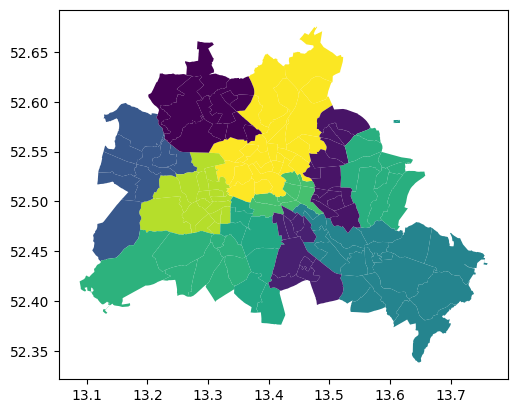

In [8]:
# replace nulls with means
gdf["median_pri"] = gdf["median_pri"].fillna(gdf["median_pri"].mean())

# and plot the result
gdf.plot(column="median_pri")

<Axes: >

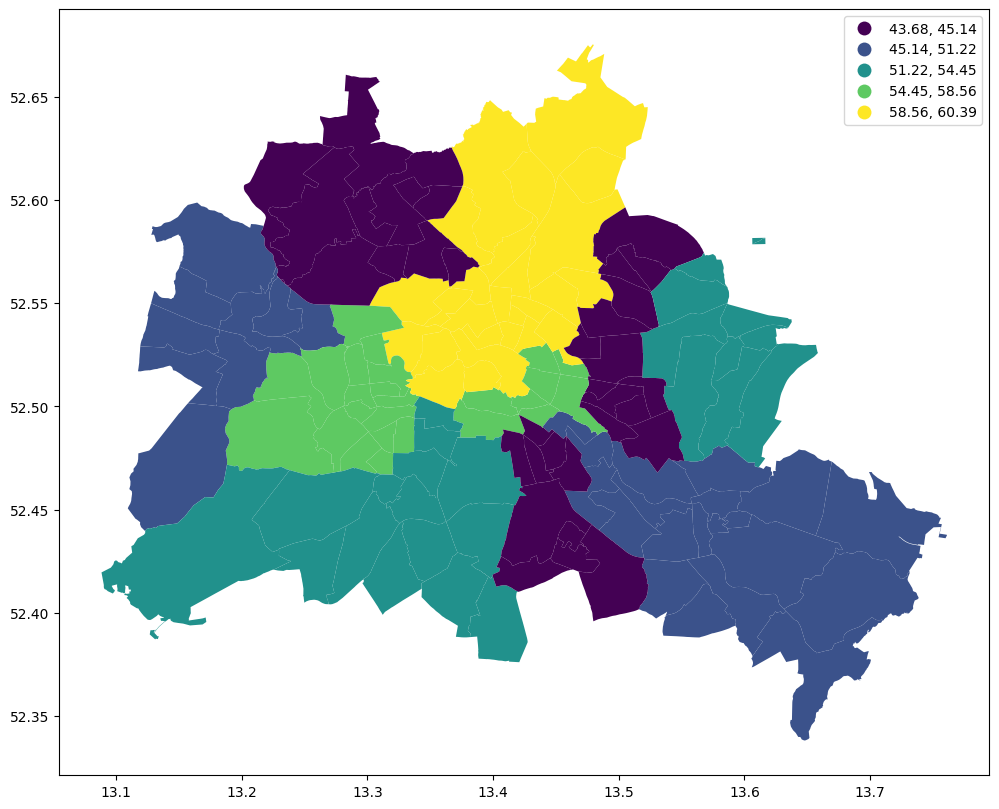

In [10]:
# now reclassify the choropleth into quantiles
# define a legend
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"aspect": "equal"})

# create the new plot
gdf.plot(column="median_pri", scheme="Quantiles", k=5, cmap="viridis", legend=True, ax=ax)

## Spatial autocorrelation
See the [original tutorial](https://pysal.org/esda/notebooks/spatial_autocorrelation_for_areal_unit_data.html#) for the full description here.

Steps include:
1) Calculate spatial similarities across each pair of observations, using a spatial weights matrix.
2) Calculate attribute similarities across each pair of observations, using a spatial lag metric.
3) Calculate and test a global Moran's I.
4) Calcualte and test local Moran's I values.

In [11]:
# create a spatial weights matrix to assess spatial similarity
df = gdf # this needs a data frame, non-spatial

# use a queen contiguity for the matrix
wq = lps.weights.Queen.from_dataframe(df, use_index=False, silence_warnings=True)
wq.transform = "r"

wq

In [12]:
# view attribute similarity using a spatial lag metric
y = df["median_pri"]

ylag = lps.weights.lag_spatial(wq, y)
ylag

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

## Global Moran's I
Now we'll calculate the global Moran's I. As a reminder, this returns a single number indicating whether there is or is not an underlying spatial structure in the data.

H0: The data are spatiall random.

HA: There is an underlying spatial clustering in the data.

In [13]:
# define the y variable of interest
y = df["median_pri"]
print(y)

0      60.282516
1      60.282516
2      58.556408
3      51.222004
4      51.222004
         ...    
135    54.246754
136    54.246754
137    43.682465
138    43.682465
139    43.682465
Name: median_pri, Length: 140, dtype: float32


In [14]:
# define a random seed to simulate pseudo p-values
np.random.seed(12345)

In [15]:
# calculate the global Moran's I
mi = esda.moran.Moran(y, wq)

# show results
print(f"Moran's I: {mi.I}")
print(f"pseudo p-value: {mi.p_sim}")

Moran's I: 0.6563069331329718
pseudo p-value: 0.001


Text(0.5, 0, "Moran's I")

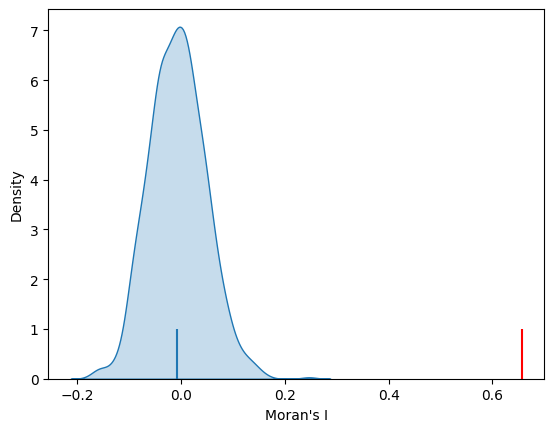

In [18]:
# visualize the actual and simulated values
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color="r")
plt.vlines(mi.EI, 0, 1)
plt.xlabel("Moran's I")

## Local Moran's I
Next we'll calculate the local Moran's I scores for each observation in the dataaset. Since there is an underlying stucture (per the Global Moran's I test), we can proceed to this in order to explore where that structure can be found on the map.

In [19]:
# again, we'll set the matrix
wq.transform = "r"

# and generate a random seed
np.random.seed(12345)

In [20]:
# now we'll also define a local spatial lag metric to visualize how it compares against the global metric
lag_price = lps.weights.lag_spatial(wq, df["median_pri"])
lag_price

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

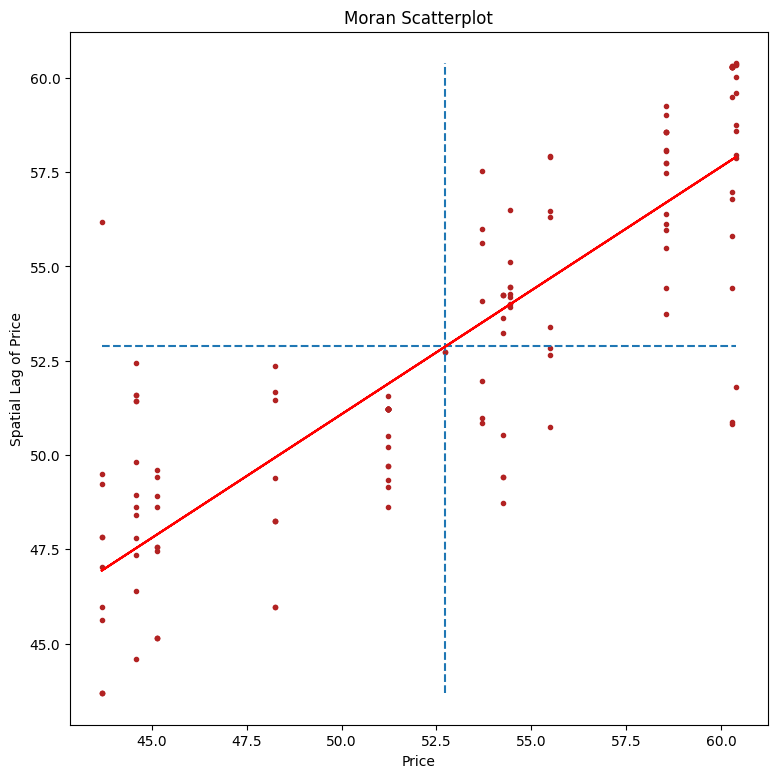

In [21]:
# we'll visualize this as a Moran scatterplot
price = df["median_pri"]
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, ".", color="firebrick")

# dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle="--")
# dashed horizontal at mean of lagged price
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle="--")

# red line of best fit using global I as slope
plt.plot(price, a + b * price, "r")
plt.title("Moran Scatterplot")
plt.ylabel("Spatial Lag of Price")
plt.xlabel("Price")
plt.show()

In [22]:

# Ensure y is a float64 array -- it resolves an error in the original script
y = np.array(y, dtype=np.float64)

# Run the local Moran
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
    li = esda.moran.Moran_Local(y, wq)

# see some results
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

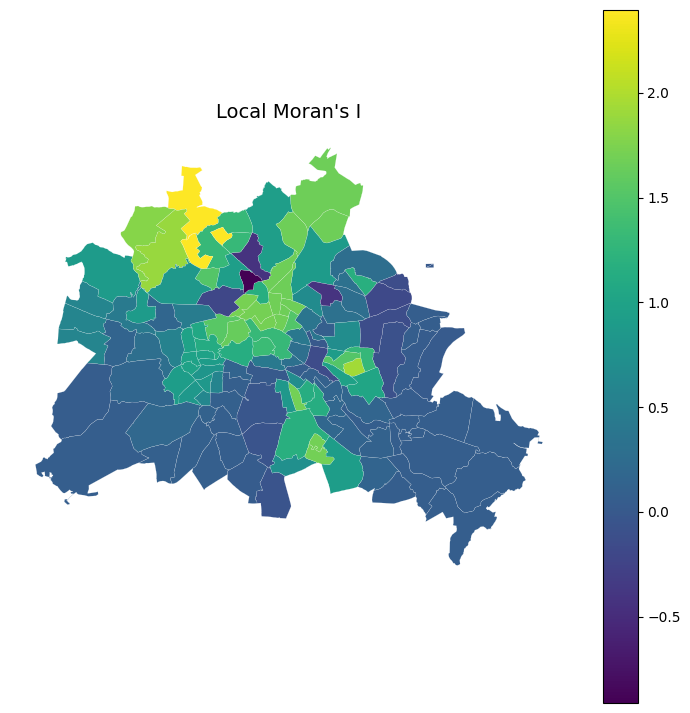

In [23]:
# Plot the local Moran scores
fig, ax = plt.subplots(1, figsize=(9, 9))
df.plot(
    column=li.Is,
    cmap="viridis",
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_title("Local Moran's I", fontsize=14)
ax.set_axis_off()
plt.show()

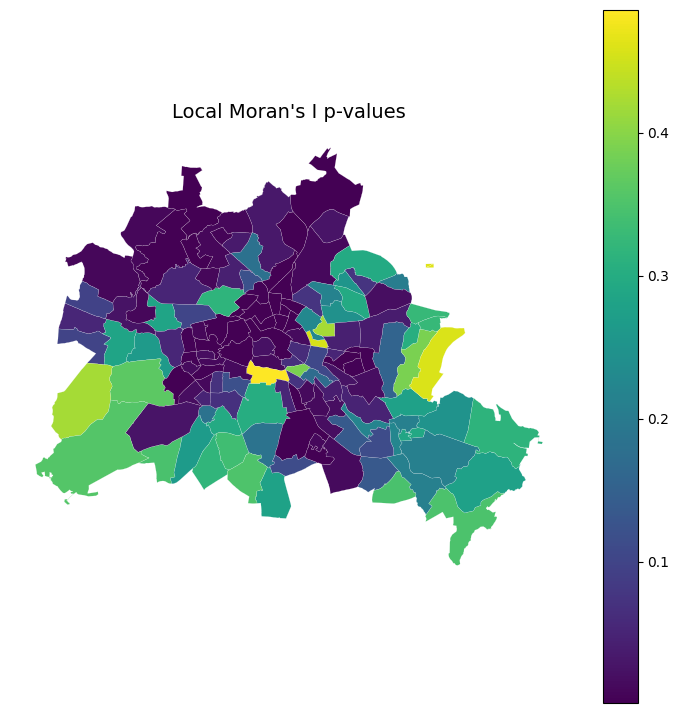

In [24]:
# plot the p-values
fig, ax = plt.subplots(1, figsize=(9, 9))
df.plot(
    column=li.p_sim,
    cmap="viridis",
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_title("Local Moran's I p-values", fontsize=14)
ax.set_axis_off()
plt.show()

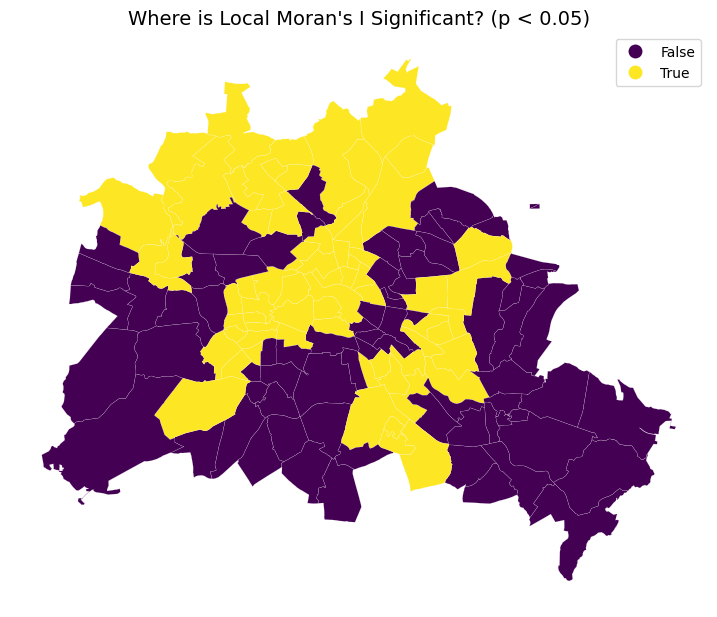

In [27]:
# Now we'll visualize 'significant' local values
# create new columns to filter
df["significant"] = li.p_sim < 0.05

# Plot the map
fig, ax = plt.subplots(1, figsize=(9, 9))
df.plot(
    column="significant",
    cmap="viridis",
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_title("Where is Local Moran's I Significant? (p < 0.05)", fontsize=14)
ax.set_axis_off()
plt.show()

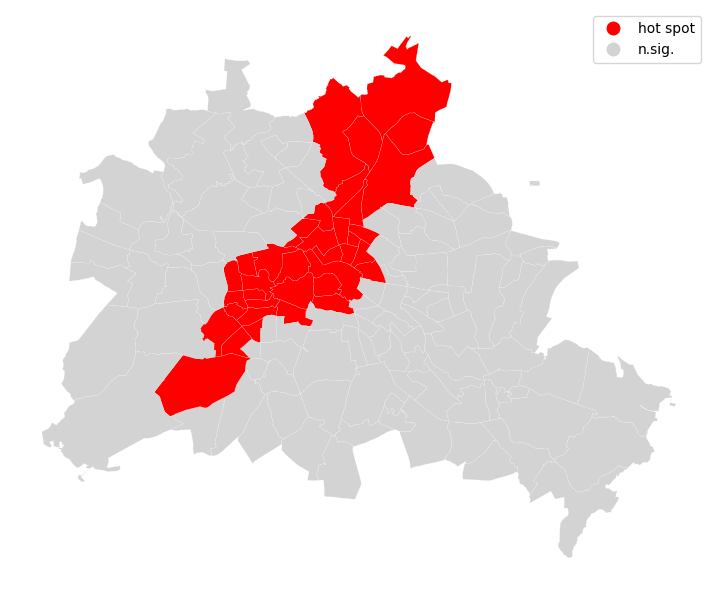

In [34]:
# hot spots
# create a hot spot variable
sig = li.p_sim < 0.05
hotspot = sig * li.q == 1
spots = ["n.sig.", "hot spot"]
labels = [spots[i] for i in hotspot * 1]

# map it
hmap = colors.ListedColormap(["red", "lightgrey"])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap=hmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_axis_off()
plt.show()

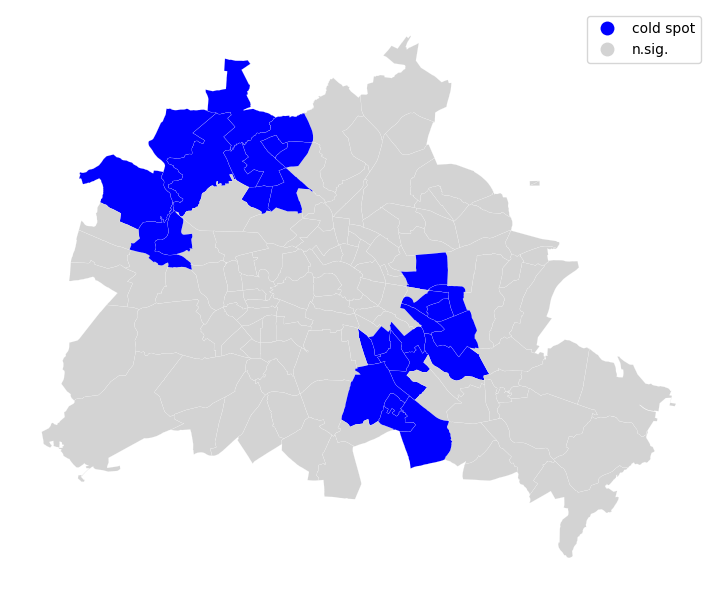

In [35]:
# cold spots
# create a cold spot variable
sig = li.p_sim < 0.05
coldspot = sig * li.q == 3
spots = ["n.sig.", "cold spot"]
labels = [spots[i] for i in coldspot * 1]

# now map it
hmap = colors.ListedColormap(["blue", "lightgrey"])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap=hmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_axis_off()
plt.show()